# Method

## Algorithm

I implemented a variation of the K2 Search algorithm shown in the book with some minor changes mostly inspired from [1]. 

The main change is that, during the main loop, when considering which parents to add to the current node I only consider the preceding nodes as feasible parents, i.e. the initial ordering of nodes is treated as a topological sort and respected as such. This gives the advantage of knowing that the graph will continue to be acyclic with every parental addition. Thus, the initial ordering plays an important role. To be able to explore different initial orderings on each trial, the initial search begins by randomizing the node ordering. 

The second change is that I included the option to bound the number of parents. The most evident benefit in this case is the reduction in computation time. But it also helps in guiding the search, moving it away from too complex structures (this turn out to be beneficial in the School Grades dataset).

The third modification involves computing only the Bayesian Score for the node under consideration. This comes as a realization (and pointed out in [1]) that the score is separable. Therefore, at each step we avoid computing the Bayesian Score for the whole graph, and use only individual scores for comparison. While not implemented in this specific instance, this allows the parallel computation of the best parental arrangement for each node. It is worth noting that this is only possible due to the algorithm treating the original ordering as a topological sort (removes constraint dependencies between nodes).

## Implementation

The code was written in Python and makes use of NetworkX (graph operations), Numpy (linear algebra and numerical operaitons), Scipy (special scientific functions) and Pandas (data frames). 

## Results

### Titanic

Score: -3802.96

Time: 0.336s

Intution: the resulting graph shows that, as is repeatedly discussed, passenger class and gender play a big role in who survived (rich people and women). Other intuitive relations: fare and class, and siblings/children and age.

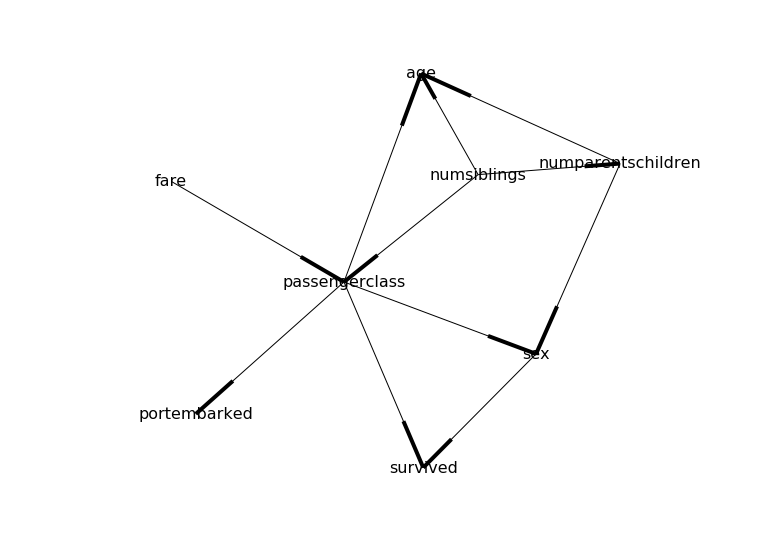

In [339]:
pos=nx.graphviz_layout(G)
nx.draw(G,pos=pos,with_labels=True, node_size=0, edge_size = 0.1, font_size=16)

### White Wine
Score: -42084.37

Time: 0.814

Intuition: Main intution is that the quality is dependent on the level of alcohol. This I can expect and agree with. Additionally, pH is a parent to fixed acidity, which makes sense. The rest of the relationships are difficult for me to interpret since I am far from a wine connoisseur.

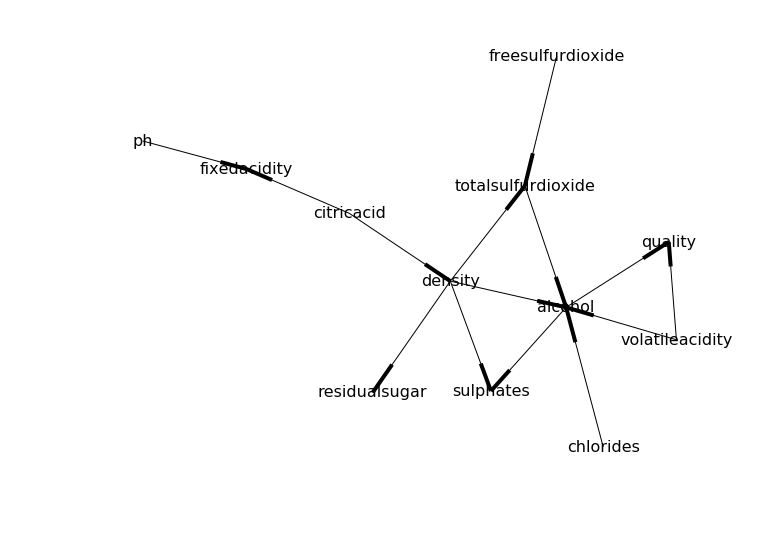

In [340]:
pos=nx.graphviz_layout(wine_dag)
nx.draw(wine_dag,pos=pos,with_labels=True, node_size=0,font_size=16)

### School Grades
Score: -44179.81

Time: 10.069

Intuition: I do not have much to say in this result. The information on the dataset is rather vague, so I can't draw any relevant conclusions.

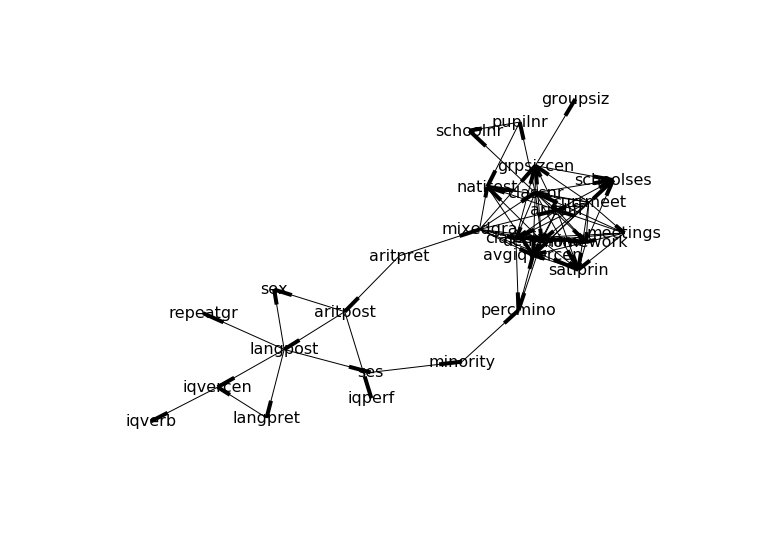

In [342]:
pos=nx.graphviz_layout(school_dag)
nx.draw(school_dag,pos=pos,with_labels=True, node_size=0, font_size=16)

## Appendix: Code

In [331]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools
from random import shuffle
from scipy.special import gammaln
from collections import OrderedDict
import matplotlib.pyplot as plt
import time
%matplotlib inline
from matplotlib import rcParams  
rcParams['figure.figsize'] = (10, 7) #Size of figure  
rcParams['figure.dpi'] = 125

In [177]:
# compute score from list of node paramters
def bayesianScore(L):
    '''
    L is a list where each entry i is
    aa numpy array of shape (q_i, r_i)
    
    we assume that alpha_ijk = 1 for all i,j,k
    
    and P(G) can be disregarded
    '''
    score = 0
    for i,m in enumerate(L):
        alphas = np.ones(m.shape)
        #print m.sum(axis=0)
        A = (gammaln(alphas.sum(axis=1)) - gammaln(alphas.sum(axis=1) + m.sum(axis=1))).sum()
        B = (gammaln(alphas + m) - gammaln(alphas)).sum(axis=0).sum()
        #print A, B
        score += (A + B).sum()
    return score

In [124]:
# compute mijk from given node and parents
def compute_counts(node, parents, dataset):
    '''
    returns a (q_i, r_i) numpy array with counts
    
    node is a string, representing the node/column
    
    parents is a list of strings
    
    dataset is a pandas dataframe
    '''
    
    # for each ijk get count of ocurrences
    if parents:
        m = pd.pivot_table(dataset[[node]+parents], 
                       index=parents, columns=node, aggfunc=len).fillna(0).as_matrix()
    else:
        vals = dataset[node].value_counts().as_matrix()
        m = np.zeros((1,len(vals)))
        m[0,:] = vals
        
    return m

In [217]:
def k2Search(dataset, max_parents=5):
    '''
    implementation of k2 search
    
    returns networkx graph
    
    dataset is a pandas dataframe
    
    '''
    dag = nx.DiGraph()
    
    # get random ordering of nodes
    nodes = list(dataset.columns)
    shuffle(nodes)
    
    #add nodes
    dag.add_nodes_from(nodes)
    
    #keep track of total score
    total_score = 0
    
    #keep track of parents
    for i,node in enumerate(nodes):
        feasible_parents = nodes[:i]
        current_parents = []
        current_counts = compute_counts(node, current_parents, dataset)
        
        #note that we only need to compare the score for the current score
        current_score = bayesianScore([current_counts])
        while feasible_parents:
            scores = []
            for j,parent in enumerate(feasible_parents):
                new_counts = compute_counts(node, current_parents + [parent], dataset)
                new_score = bayesianScore([new_counts])
                #print i,j, new_score
                scores.append(new_score)
            best_score = np.max(scores)
                
            if best_score > current_score:
                new_parent = feasible_parents.pop(np.argmax(scores))
                current_parents.append(new_parent)
                dag.add_edge(new_parent, node)
                current_score = best_score
                if len(current_parents) >= max_parents:
                    # reached max parenthood
                    break
            else:
                #  basically no new parent would improve the score
                break
                    
        #update the total score
        total_score += current_score
    return total_score, dag

In [275]:
def compute_score(dag, dataset):
    nodes = dag.nodes()
    score = 0
    for i, node in enumerate(nodes):
        parents = dag.predecessors(node)
        counts = compute_counts(node, parents, dataset)
        score += bayesianScore([counts])
    return score

In [272]:
titanicdf = pd.read_csv('assets/titanic.csv')
whitewinedf = pd.read_csv('assets/whitewine.csv')
schoolgradesdf = pd.read_csv('assets/schoolgrades.csv')

In [265]:
t0 = time.time()
score, G = k2Search(titanicdf, max_parents=100)
dt = time.time() - t0
print compute_score(G, titanicdf), dt

-3802.96021241 0.336395978928


In [266]:
with open('assets/titanic.gph','w') as f:
    text = ''
    for e in G.edges():
        text += '\n' + e[0] + ',' + e[1]
    f.write(text)

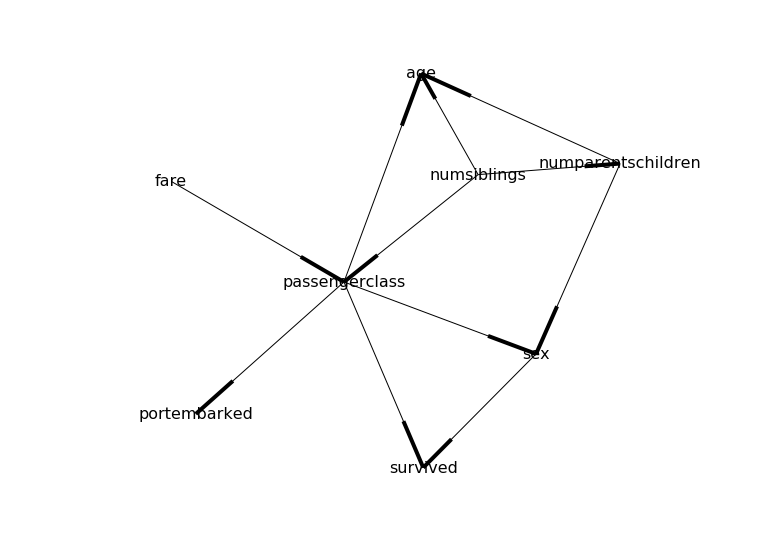

In [337]:
pos=nx.graphviz_layout(G)
nx.draw(G,pos=pos,with_labels=True, node_size=0, edge_size = 0.1, font_size=16)

In [303]:
t0 = time.time()
wine_score, wine_dag = k2Search(whitewinedf, max_parents=100)
dt_wine = time.time() - t0
print compute_score(wine_dag, whitewinedf), dt_wine

-42084.3787949 0.814061880112


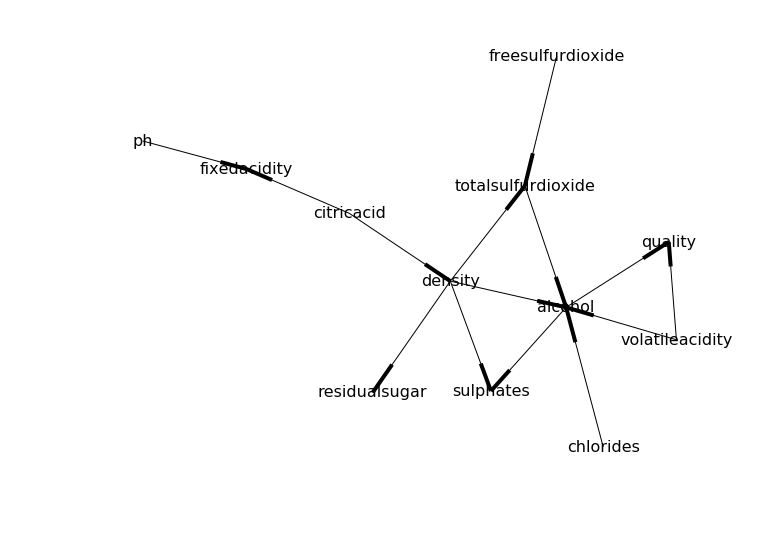

In [336]:
pos=nx.graphviz_layout(wine_dag)
nx.draw(wine_dag,pos=pos,with_labels=True, node_size=0,font_size=16)

In [305]:
t0 = time.time()
school_score, school_dag = k2Search(schoolgradesdf, max_parents=10)
dt_school = time.time() - t0
print compute_score(school_dag, schoolgradesdf), dt_school

-44179.8184466 10.069065094


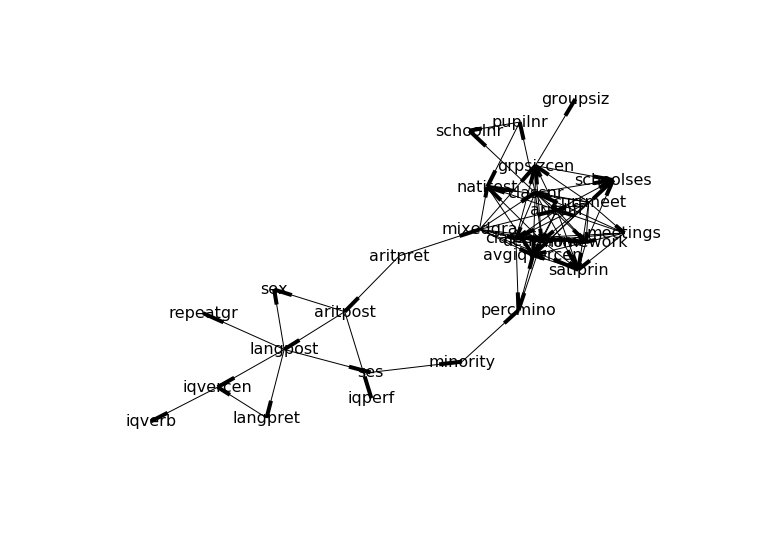

In [338]:
pos=nx.graphviz_layout(school_dag)
nx.draw(school_dag,pos=pos,with_labels=True, node_size=0, font_size=16)

In [307]:
with open('assets/whitewine.gph','w') as f:
    text = ''
    for e in wine_dag.edges():
        text += '\n' + e[0] + ',' + e[1]
    f.write(text)

with open('assets/schoolgrades.gph','w') as f:
    text = ''
    for e in school_dag.edges():
        text += '\n' + e[0] + ',' + e[1]
    f.write(text)